In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os,sklearn,tqdm,nltk

from collections import Counter
from datetime import datetime

from gensim import corpora
from gensim import models
from scipy.sparse import csr_matrix

In [34]:
import gensim
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

# 1. load data
### counter

In [35]:
counter = Counter()

counter_dir="C:/Users/Evan/MyFile/Fortune-street/007 oil_price/oilprice_news_analyze/002 data/003 outcome_data/word_counter_data/"
txt_dir="C:/Users/Evan/MyFile/Fortune-street/007 oil_price/oilprice_news_analyze/002 data/002 corpus_data/token_txt_data/"
# C:\Users\Evan\MyFile\Fortune-street\007 oil_price\oilprice_news_analyze\002 data\002 corpus_data\token_txt_data

list_counter_filenames=list(os.walk(counter_dir))[0][2]
print(list_counter_filenames)
list_txt_source=list(os.walk(txt_dir))[0][1]
print(list_txt_source)

for counter_file in list_counter_filenames:
    if counter_file.startswith("word_counter"):
        print(counter_dir+counter_file)
        current_counter=np.load(counter_dir+counter_file)
        counter.update(current_counter.tolist())
counter.most_common(10)

['word_counter.npy', 'word_counter_2019_02_08.npy', 'word_counter_2019_02_12.npy', 'word_counter_2019_02_26.npy']
['cnbc_news_data', 'oil_price_news_data', 'uk_reuters_news_data']
C:/Users/Evan/MyFile/Fortune-street/007 oil_price/oilprice_news_analyze/002 data/003 outcome_data/word_counter_data/word_counter.npy
C:/Users/Evan/MyFile/Fortune-street/007 oil_price/oilprice_news_analyze/002 data/003 outcome_data/word_counter_data/word_counter_2019_02_08.npy
C:/Users/Evan/MyFile/Fortune-street/007 oil_price/oilprice_news_analyze/002 data/003 outcome_data/word_counter_data/word_counter_2019_02_12.npy
C:/Users/Evan/MyFile/Fortune-street/007 oil_price/oilprice_news_analyze/002 data/003 outcome_data/word_counter_data/word_counter_2019_02_26.npy


[('the', 563896),
 ('to', 307474),
 ('in', 252087),
 ('of', 248237),
 ('and', 234697),
 ('a', 220905),
 ('on', 128028),
 ('s', 119098),
 ('by', 117766),
 ('said', 99721)]

### load news data

In [23]:
# 'CC'表示并列连词，'RB'表示副词，'IN'表示介词，'NN'表示名词，'JJ'表示形容词
def pos_filter(aListToken):
    remove_pos_list=['IN','DT','FW','CC','TO','MD','WP','LS','EX','PDT','RP','PRP$']
    text1=aListToken
    if '' in text1:
        text1.remove('')
    pos_list=nltk.pos_tag(text1)
    return([word for word,pos in pos_list if pos not in remove_pos_list])

In [36]:
def read_news_txt_file(aFilepath):
    token_list=[]
    with open(aFilepath,"r",encoding='utf8') as f:
        news_title=f.readline()
        line = news_title
        while line :
            line = f.readline()
            token_list.append(line.strip())
    return(news_title,token_list)

full_list=[]
for aSource in list_txt_source:
    for subpath , null , list_news_filenames in tqdm.tqdm(list(os.walk(txt_dir+aSource))[1:]):
        news_publish_date=subpath.split("\\")[1]
        source=subpath.split("\\")[0].split("/")[-1]
        for aFilename in list_news_filenames:
            aFilepath="/".join([subpath, aFilename])
            news_title,news_tokens_list=(read_news_txt_file(aFilepath))
            
            ##apply pos filter and save
            pos_filtered_Filepath=aFilepath.replace('token_txt_data','token_pos_filtered_txt_data')
            pos_filtered_dir='/'.join(pos_filtered_Filepath.split('/')[:-1])
            if not os.path.exists(pos_filtered_dir):
                os.makedirs(pos_filtered_dir)
            filtered=pos_filter(news_tokens_list)
            a_title,a_tokens=news_title,filtered
            with open(pos_filtered_Filepath, "w",encoding="utf8") as text_file:
                text_file.writelines(a_title.lower()+"\n")
                for token in a_tokens:
                    text_file.write(token+"\n")
                    
            ##append to full list
            out_dict={'news_publish_date':news_publish_date,
                      'news_title':news_title,
                      'news_tokens_list':news_tokens_list,
                      'source':source,
                      'news_pos_filtered_tokens_list':filtered}
            
            full_list.append(out_dict)
            
full_news_df=pd.DataFrame(full_list)
full_news_df.head(10)

100%|██████████| 373/373 [10:25<00:00,  2.14s/it]


news_pos_filtered_tokens_list news_publish_date  \
0  [singapore, dec, reuters, oil, prices, slumped...        2018-12-04   
1  [singapore, dec, reuters, oil, prices, slipped...        2018-12-04   
2  [heating, oil, futures, turn, negative, trade,...        2018-12-04   
3  [oil, futures, fall, trade, api, data, show, s...        2018-12-04   
4  [opec, meeting, singapore, dec, reuters, oil, ...        2018-12-05   
5  [singapore, dec, reuters, oil, prices, dipped,...        2018-12-05   
6  [oil, prices, extend, gains, brent, crude, mor...        2018-12-05   
7  [singapore, dec, reuters, oil, prices, fell, w...        2018-12-05   
8  [singapore, dec, reuters, oil, prices, fell, w...        2018-12-05   
9  [decision, singapore, dec, reuters, oil, price...        2018-12-06   

                                          news_title  \
0  update 3-oil prices skid with global stock mar...   
1  u.s. oil prices slide with global markets on e...   
2  heating oil futures turn negative in post-sett...   
3  oil futures fall in post-settlement trade afte...   
4  update 1-oil prices dip as stock markets slide...   
5  oil prices ease in cautious trading ahead of o...   
6  oil prices extend gains, brent crude up by mor...   
7  update 5-oil prices fall on global growth conc...   
8  update 4-oil prices slip on global growth conc...   
9  oil firms on drop in us crude stocks, market a...   

                                    news_tokens_list          source  
0  [singapore, dec, reuters, oil, prices, slumped...  cnbc_news_data  
1  [singapore, dec, reuters, oil, prices, slipped...  cnbc_news_data  
2  [heating, oil, futures, turn, negative, in, tr...  cnbc_news_data  
3  [oil, futures, fall, in, trade, after, api, da...  cnbc_news_data  
4  [opec, meeting, singapore, dec, reuters, oil, ...  cnbc_news_data  
5  [singapore, dec, reuters, oil, prices, dipped,...  cnbc_news_data  
6  [oil, prices, extend, gains, brent, crude, up,...  cnbc_news_data  
7  [singapore, dec, reuters, oil, prices, fell, o...  cnbc_news_data  
8  [singapore, dec, reuters, oil, prices, fell, o...  cnbc_news_data  
9  [decision, singapore, dec, reuters, oil, price...  cnbc_news_data

In [37]:
full_news_df.news_pos_filtered_tokens_list

0        [singapore, dec, reuters, oil, prices, slumped...
1        [singapore, dec, reuters, oil, prices, slipped...
2        [heating, oil, futures, turn, negative, trade,...
3        [oil, futures, fall, trade, api, data, show, s...
4        [opec, meeting, singapore, dec, reuters, oil, ...
5        [singapore, dec, reuters, oil, prices, dipped,...
6        [oil, prices, extend, gains, brent, crude, mor...
7        [singapore, dec, reuters, oil, prices, fell, w...
8        [singapore, dec, reuters, oil, prices, fell, w...
9        [decision, singapore, dec, reuters, oil, price...
10       [vienna, dec, reuters, opec, tentatively, agre...
11       [slide, london, dec, reuters, yields, german, ...
12       [vienna, dec, reuters, opec, tentatively, agre...
13       [vienna, dec, reuters, opec, tentatively, agre...
14       [brent, crude, oil, futures, fall, pct, wti, f...
15       [crude, futures, extend, drop, falling, day, b...
16       [meeting, singapore, dec, reuters, oil, prices.

In [41]:
dictionary = corpora.Dictionary(full_news_df.news_pos_filtered_tokens_list)
# dictionary.save(os.path.join(DICT_FOLDER, str(saving_date)+'.dict'))  # store the dictionary, for future reference
print(dictionary)
print(dictionary.token2id)

Dictionary(51540 unique tokens: ['activity', 'added', 'administration', 'again', 'america']...)
{'activity': 0, 'added': 1, 'administration': 2, 'again': 3, 'america': 4, 'american': 5, 'analyst': 6, 'announced': 7, 'api': 8, 'are': 9, 'attention': 10, 'average': 11, 'averaged': 12, 'bank': 13, 'barrel': 14, 'barrels': 15, 'be': 16, 'beijing': 17, 'brent': 18, 'broadly': 19, 'cents': 20, 'china': 21, 'chinese': 22, 'close': 23, 'commodity': 24, 'council': 25, 'country': 26, 'crude': 27, 'data': 28, 'deal': 29, 'dec': 30, 'decelerating': 31, 'desirable': 32, 'did': 33, 'disputes': 34, 'donald': 35, 'down': 36, 'drop': 37, 'due': 38, 'economic': 39, 'economies': 40, 'economy': 41, 'editing': 42, 'employment': 43, 'expected': 44, 'far': 45, 'fiscal': 46, 'followed': 47, 'further': 48, 'futures': 49, 'global': 50, 'gloystein': 51, 'glut': 52, 'goods': 53, 'government': 54, 'growing': 55, 'guidance': 56, 'have': 57, 'headwinds': 58, 'henning': 59, 'high': 60, 'impact': 61, 'import': 62, 'im

In [85]:
corpus = [dictionary.doc2bow(text) for text in full_news_df.news_tokens_list]
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 2),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 2),
  (14, 6),
  (15, 2),
  (16, 1),
  (17, 2),
  (18, 4),
  (19, 1),
  (20, 1),
  (21, 3),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 3),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 3),
  (37, 1),
  (38, 1),
  (39, 5),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 2),
  (44, 2),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 2),
  (50, 3),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 2),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 2),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 2),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 2),
  (75, 1),
  (76, 1),
  (77, 2),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 2),
  (82, 3),
  (83, 1),
  (84, 1),
  (85, 2),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 6)

In [87]:
from gensim import models

tfidf = models.TfidfModel(corpus,id2word=dictionary)
corpus_tfidf = tfidf[corpus]
for id_num,doc in enumerate(corpus_tfidf[:10]):
    print(id_num,doc)
    

0 [(0, 0.0611933492937471), (1, 0.03327758547173767), (2, 0.042950158576753175), (3, 0.05479654948884892), (4, 0.06103284864908788), (5, 0.05319778981809577), (6, 0.04802885190553861), (7, 0.050148918673842365), (8, 0.0999154130660046), (9, 0.02372266822415496), (10, 0.08174449813576401), (11, 0.04106261038661957), (12, 0.0888176024925926), (13, 0.07816301114615568), (14, 0.1844807420898461), (15, 0.06818969507916867), (16, 0.01101072795257721), (17, 0.09908655724950396), (18, 0.13653929289392158), (19, 0.08418377595183002), (20, 0.04931035575963445), (21, 0.0845325417665703), (22, 0.04006052775641125), (23, 0.043027837839932914), (24, 0.06166158122753073), (25, 0.07539344367647136), (26, 0.029384786836523655), (27, 0.06616727821911815), (28, 0.032569844048107754), (29, 0.03213319915735997), (30, 0.067194272900928), (31, 0.14184946929394443), (32, 0.14459621521899135), (33, 0.038689332478392124), (34, 0.08042337282260101), (35, 0.03593439185453013), (36, 0.07643385712184052), (37, 0.05

7 [(0, 0.0521466837648629), (1, 0.02835791382692334), (2, 0.036600518893015084), (3, 0.093391140396123), (4, 0.10401982223574543), (5, 0.045333166996913296), (6, 0.040928391415298394), (7, 0.04273503302918417), (8, 0.08514417838738876), (9, 0.02021557068245285), (10, 0.06965960423804889), (11, 0.03499202091573744), (12, 0.07568703925162974), (13, 0.06660759496562685), (14, 0.15720758921508227), (15, 0.05810870799450071), (16, 0.009382930582991486), (17, 0.08443785845804078), (18, 0.11635367912023849), (19, 0.07173826556901214), (20, 0.0840408821483904), (21, 0.0960472943376291), (22, 0.06827616714813656), (23, 0.036666714256054896), (24, 0.05254569350793837), (25, 0.06424747314399226), (26, 0.02504061641252053), (27, 0.07518037330736804), (28, 0.027754803053754818), (29, 0.054765421214930325), (30, 0.05726044644091141), (31, 0.12087881285884762), (32, 0.12321948701362026), (33, 0.03296960223797571), (34, 0.06853379065349476), (35, 0.030621944867337474), (36, 0.0651340745728492), (37, 0

9 [(9, 0.01348636894945231), (13, 0.04443577748323708), (14, 0.034959183741946696), (15, 0.11629780145708041), (16, 0.012519227446708811), (18, 0.038811386279680456), (20, 0.05606600779637806), (23, 0.04892276793853034), (27, 0.17554220646923374), (30, 0.07640006993052999), (37, 0.057968882401456624), (39, 0.036247106949525265), (42, 0.0039638927356343955), (49, 0.08486750037286153), (50, 0.055241274981649116), (51, 0.07905158837782689), (57, 0.012853838556080821), (59, 0.07884995842546651), (64, 0.041335639574990736), (67, 0.06774687683867499), (68, 0.04238856393947819), (69, 0.13003228827145033), (72, 0.0073847743031782405), (75, 0.0837636402038186), (77, 0.017354393358299712), (81, 0.0347711693511654), (85, 0.11928195891515336), (87, 0.016104233397082515), (91, 0.0678937167514337), (92, 0.061849052272205045), (94, 0.03197298980294527), (95, 0.04548051895349929), (97, 0.1037910183689335), (100, 0.06939238402127608), (101, 0.05913309209605229), (105, 0.08914368176074433), (108, 0.0060

In [81]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=10)  # initialize an LSI transformation
corpus_lsi = lsi_model[corpus_tfidf]  # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi
lsi_model.print_topics(10)

[(0,
  '0.197*"percent" + 0.140*"crude" + 0.135*"oil" + 0.129*"trade" + 0.128*"dollar" + 0.107*"index" + 0.106*"china" + 0.103*"bpd" + 0.099*"prices" + 0.099*"opec"'),
 (1,
  '-0.216*"dollar" + -0.209*"percent" + 0.199*"bpd" + -0.189*"index" + 0.160*"opec" + 0.150*"oil" + 0.143*"iran" + 0.142*"million" + -0.125*"stocks" + 0.123*"production"'),
 (2,
  '0.230*"bpd" + 0.209*"crude" + 0.201*"opec" + -0.146*"gas" + -0.141*"lng" + -0.141*"power" + 0.139*"futures" + -0.135*"coal" + 0.133*"barrels" + 0.132*"barrel"'),
 (3,
  '0.429*"iran" + 0.223*"sanctions" + -0.204*"lng" + 0.199*"iranian" + 0.158*"nuclear" + -0.152*"gas" + 0.140*"tehran" + 0.138*"trump" + 0.138*"saudi" + -0.128*"million"'),
 (4,
  '0.313*"lng" + 0.260*"tonnes" + 0.251*"china" + 0.237*"imports" + 0.223*"iran" + -0.163*"saudi" + -0.161*"opec" + 0.161*"coal" + 0.155*"iranian" + 0.125*"sanctions"'),
 (5,
  '-0.377*"lng" + -0.329*"saudi" + -0.236*"opec" + -0.194*"arabia" + 0.136*"rigs" + -0.132*"gas" + 0.131*"crude" + -0.125*"ara

In [58]:
data = []
rows = []
cols = []
line_count = 0
for line in corpus_lsi:  # lsi_corpus_total 是之前由gensim生成的lsi向量
    for elem in line:
        rows.append(line_count)
        cols.append(elem[0])
        data.append(elem[1])
    line_count += 1
lsi_sparse_matrix = csr_matrix((data,(rows,cols))) # 稀疏向量
lsi_matrix = lsi_sparse_matrix.toarray()  # 密集向量

In [97]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3)
pca.fit(lsi_matrix)
three_dim_lsi=pca.transform(lsi_matrix[::40])

In [98]:
from sklearn.cluster import KMeans
kmean_model = KMeans(n_clusters=3)
kmean_model.fit(three_dim_lsi)
labels= kmean_model.predict(three_dim_lsi)
cluster_centers = kmean_model.cluster_centers_

In [99]:
if cluster_centers.shape[1]==3:
    reshaped_cluster_centers=cluster_centers.reshape(3,-1)
else:
    reshaped_cluster_centers=pca.transform(cluster_centers).reshape(3,-1)
    
reshaped_3_dim_lsi=pca.transform(lsi_matrix[::40]).reshape(3,-1)

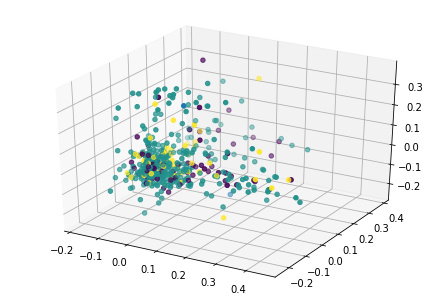

In [100]:
from mpl_toolkits.mplot3d import Axes3D
import random
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(reshaped_cluster_centers[0],reshaped_cluster_centers[1],reshaped_cluster_centers[2],"rD")
ax.scatter(reshaped_3_dim_lsi[0],reshaped_3_dim_lsi[1],reshaped_3_dim_lsi[2],c=labels)
